# CDL Quantum Hackathon 2020
----
## PennyLane challenge
>**Challenge description**: PennyLane contains the quantum-aware optimizers Rotosolve, QNG, and Rosalin. Rewrite them as PyTorch or TensorFlow native optimizers and provide a tutorial showing how they can be used to train a quantum model.

### Description of notebook
This notebook demonstrates that two of the specified quantum-aware optimizers; Rotosolve and Quantum Natural Gradient are implemented in a PyTorch generic way. They *do* require pennylane qNode circuits to provide some initial functionality, and they borrow the Fubini metric tensor calculation from PennyLane

In [1]:
from quantum_aware_optims import *
import pennylane as qml
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

### The RotoSolve quantum optimizer
----
The example is from https://pennylane.ai/qml/demos/tutorial_rotoselect.html

In [2]:
n_wires = 2

dev = qml.device("default.qubit", analytic=True, wires=2)

def ansatz(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliY(1))

@qml.qnode(dev)
def circuit2(params):
    ansatz(params)
    return qml.expval(qml.PauliX(0))

### Hamiltonian definition
We assume that the required expectation values that will be present in the final quantum circuit are evaluated from a list of quantum circuits, and that these are joined together corresponding to some mixing coefficients.
Further, we specify some initial parameters

In [3]:
qcircuits = [circuit, circuit2]
proportions = [0.5, 1.2, -0.2]
init_params = torch.tensor([0.1, 0.25])

We iterate the rotosolve algorithm 20 times

In [4]:
n_steps = 20
optim = RotoSolve(init_params,qcircuits,proportions)
"""RotoSolve inherits from torch.optim.Optimizer, but relies heavily
on native python operations. However, since it's non-gradient optimization
can't flow the gradients into a classical layer anyway"""
for i in range(n_steps):
    loss = optim.step()
print(optim.final_params)

[2.4292036294937134, -1.5707963705062866]


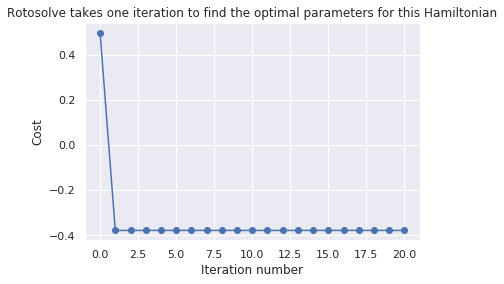

In [5]:
# Plotting results
plt.plot(list(range(n_steps+1)),optim.losses, 'o-')
plt.xlabel("Iteration number")
plt.ylabel("Cost")
plt.title("Rotosolve takes one iteration to find the optimal parameters for this Hamiltonian")
plt.show()

In [6]:
%%timeit
optim = RotoSolve(init_params,qcircuits,proportions)
loss = optim.step()

16.2 ms ± 424 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# Let's scale it up to a more complicated Hamiltonian
n_wires = 5

dev = qml.device("default.qubit", analytic=True, wires=n_wires)

def ansatz(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(params[2], wires=0)
    qml.RY(params[4], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(params[2], wires=0)
    qml.RY(params[4], wires=1)

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliY(1)), qml.expval(qml.PauliZ(2)),qml.expval(qml.PauliY(4))

@qml.qnode(dev)
def circuit2(params):
    ansatz(params)
    return qml.expval(qml.PauliX(0)), qml.expval(qml.PauliX(1)), qml.expval(qml.PauliY(2))

qcircuits = [circuit, circuit2]
proportions = [0.5, 1.2, -0.2, 0.3, -0.8, 0.9, -1.8]
init_params = torch.randn(7)

In [8]:
n_steps = 20
optim = RotoSolve(init_params,qcircuits,proportions)
"""RotoSolve inherits from torch.optim.Optimizer, but relies heavily
on native python operations. However, since it's non-gradient optimization
can't flow the gradients into a classical layer anyway"""
for i in range(n_steps):
    loss = optim.step()
print(optim.final_params)

[2.4292036294937134, -1.5707860198963317, -1.5707963705062866, -1.5707963705062866, 7.3909759521484375e-06, -1.5707963705062866, -1.5707963705062866]


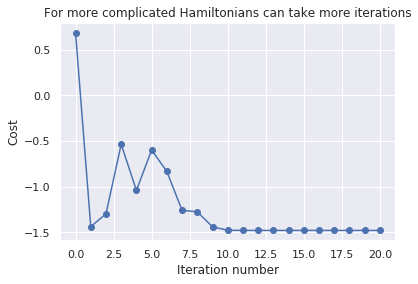

In [9]:
# Plotting results
plt.plot(list(range(n_steps+1)),optim.losses, 'o-')
plt.xlabel("Iteration number")
plt.ylabel("Cost")
plt.title("For more complicated Hamiltonians can take more iterations")
plt.show()

In [12]:

dev = qml.device("default.qubit", wires=3)


@qml.qnode(dev)
def circuit(inputs, params):
    # |psi_0>: state preparation
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[0], wires=0)
    qml.RZ(params[1], wires=1)

    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    # V_1(theta2, theta3): Parametrized layer 1
    qml.RY(params[2], wires=1)
    qml.RX(params[3], wires=2)

    # W2: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    return qml.expval(qml.PauliY(0))

qlayer = qml.qnn.TorchLayer(circuit, {"params": 4})

def loss_func(theta):
    loss = qlayer(theta)
    return loss

params = np.array([0.5, -0.123, 0.543, 0.233])
qlayer.params.data = torch.tensor(params)
optimQNG = QuantumNaturalGradientOptim([qlayer.params], circuit, lr=0.1)
lossesQNG = []
for i in range(100):
    loss = loss_func(qlayer.params)
    lossesQNG.append(loss)
    loss.backward()
    optimQNG.step()
    optimQNG.zero_grad()

In [13]:

dev = qml.device("default.qubit", wires=3)


@qml.qnode(dev)
def circuit(inputs, params):
    # |psi_0>: state preparation
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[0], wires=0)
    qml.RZ(params[1], wires=1)

    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    # V_1(theta2, theta3): Parametrized layer 1
    qml.RY(params[2], wires=1)
    qml.RX(params[3], wires=2)

    # W2: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    return qml.expval(qml.PauliY(0))

qlayer = qml.qnn.TorchLayer(circuit, {"params": 4})

def loss_func(theta):
    loss = qlayer(theta)
    return loss

params = np.array([0.5, -0.123, 0.543, 0.233])
qlayer.params.data = torch.tensor(params)
optim = SGD([qlayer.params], lr=0.1)
losses = []
for i in range(100):
    loss = loss_func(qlayer.params)
    losses.append(loss)
    loss.backward()
    optim.step()
    optim.zero_grad()

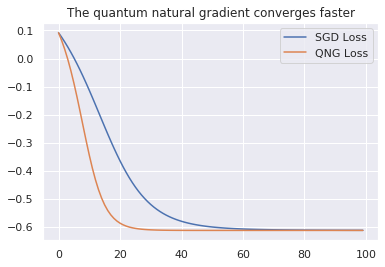

In [19]:
plt.plot(list(range(100)),losses, label='SGD Loss')
plt.plot(list(range(100)),lossesQNG, label='QNG Loss')
plt.legend()
plt.title("The quantum natural gradient converges faster")
plt.show()